In [1]:
import sys
sys.path.append('..')

from helpers.helpers import load_matches_df
from preprocess.features import get_heroes_dummies
from preprocess.features import HERO_COLUMNS

matches = load_matches_df()

In [2]:
import pandas as pd

columns = ['match_id', 'radiant_win'] + HERO_COLUMNS
df = matches[columns].set_index('match_id')
df.dropna(inplace=True)

radiant_heroes, dire_heroes = get_heroes_dummies(df)

df = pd.concat([df, radiant_heroes, dire_heroes], axis=1, join_axes=[df.index])
df.drop(HERO_COLUMNS, axis=1, inplace=True)

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score, KFold
from sklearn.preprocessing import scale

y = df['radiant_win']
X = scale(df.drop(['radiant_win'], axis=1))

cv = KFold(len(X), shuffle=True, n_folds=5, random_state=42)
grid = {'C': [0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2']}
clf = LogisticRegression(random_state=42)
model = GridSearchCV(clf, grid, cv=cv)
model.fit(X, y)

print(model.best_params_)
print(model.best_score_)

{'penalty': 'l1', 'C': 0.1}
0.594369272505


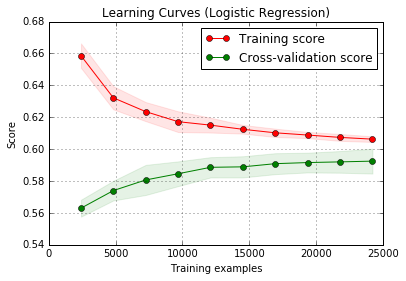

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import cross_validation
from sklearn.linear_model import LogisticRegression
from sklearn.learning_curve import learning_curve

X = scale(df.drop(['radiant_win'], axis=1))
y = df['radiant_win']

cv = cross_validation.ShuffleSplit(X.shape[0], n_iter=10, test_size=0.2, random_state=42)
estimator = LogisticRegression(penalty='l1', random_state=42, C=0.1)

plt.figure()
train_sizes=np.linspace(.1, 1.0, 10)
plt.title("Learning Curves (Logistic Regression)")
plt.xlabel("Training examples")
plt.ylabel("Score")
train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv,
                                                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 10))
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.legend(loc="best")

plt.show()

I have a hypothesis: what if teams with `team_id` are much stronger, because they are persistent teams, train together, more proficient, etc.

In [3]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score, KFold
from sklearn.preprocessing import scale

team_persistence = pd.DataFrame({
        "is_radiant_team_persistent": matches['radiant_team_id'].notnull().fillna(0).astype(int),
        "is_dire_team_persistent": matches['dire_team_id'].notnull().fillna(0).astype(int)
    })

team_persistence = team_persistence.set_index(df.index)

df = pd.concat([df, team_persistence], axis=1)

y = df['radiant_win']
X = scale(df.drop(['radiant_win'], axis=1))

cv = KFold(len(X), shuffle=True, n_folds=5, random_state=42)
grid = {'C': [0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2']}
clf = LogisticRegression(random_state=42)
model = GridSearchCV(clf, grid, cv=cv)
model.fit(X, y)

print(model.best_params_)
print(model.best_score_)

{'penalty': 'l1', 'C': 0.1}
0.594038442452


The accuracy drops by 0.0001, and maybe this is good: there is no difference, weather a team is persistent or not. But nevertheless we should take into account best teams: they will definitely win outsiders